# Lending Club - Loan Approval Process Optimization

# 4. Modeling

## 4.1 Imports

In [1]:
# Import the libraries necessary for the current task
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn import __version__ as sklearn_version
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (cross_validate, cross_val_score, cross_val_predict, train_test_split, 
                                     StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# pandas Configuration
pd.set_option("max_rows", 120)
pd.set_option("max_columns", 120)
pd.set_option("display.max_colwidth", None)

## 4.2 Data

### 4.2.1 Data Loading

In [2]:
# Load the CSV data
LC_data = pd.read_csv(r"C:\Users\lastr\Desktop\GitHub\Lending_Club_Capstone\data\lending_club_loans_preprocessed.csv")

### 4.2.2 Data Conversion

In [3]:
# Convert earliest_cr_line, last_credit_pull_d to datetime again
LC_data['earliest_cr_line'] = pd.to_datetime(LC_data['earliest_cr_line'])
LC_data['last_credit_pull_d'] = pd.to_datetime(LC_data['last_credit_pull_d'])

In [4]:
# Convert earliest_cr_line, last_credit_pull_d to ordinal numeric
LC_data['earliest_cr_line'] = LC_data['earliest_cr_line'].apply(lambda x: x.toordinal())
LC_data['last_credit_pull_d'] = LC_data['last_credit_pull_d'].apply(lambda x: x.toordinal())

### 4.2.3 Data Overview

In [5]:
# Summary of the data
LC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39239 entries, 0 to 39238
Data columns (total 92 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            39239 non-null  float64
 1   installment                          39239 non-null  float64
 2   grade                                39239 non-null  int64  
 3   emp_length                           39239 non-null  int64  
 4   annual_inc                           39239 non-null  float64
 5   loan_type                            39239 non-null  int64  
 6   dti                                  39239 non-null  float64
 7   delinq_2yrs                          39239 non-null  float64
 8   earliest_cr_line                     39239 non-null  int64  
 9   inq_last_6mths                       39239 non-null  float64
 10  open_acc                             39239 non-null  float64
 11  pub_rec                     

In [6]:
# First 5 entries of the data
LC_data.head()

,loan_amnt,installment,grade,emp_length,annual_inc,loan_type,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies,fico_range_avg,term_ 36 months,term_ 60 months,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,5000.0,162.87,1,10,24000.0,1,27.65,0.0,724642,1.0,3.0,0.0,13648.0,83.7,9.0,736208,0.0,737.0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.0,59.83,2,0,30000.0,0,1.00,0.0,729845,5.0,3.0,0.0,1687.0,9.4,4.0,736208,0.0,742.0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.0,84.33,2,10,12252.0,1,8.72,0.0,730790,2.0,2.0,0.0,2956.0,98.5,10.0,736208,0.0,737.0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10000.0,339.31,2,10,49200.0,1,20.00,0.0,728690,1.0,10.0,0.0,5598.0,21.0,37.0,736055,0.0,692.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5000.0,156.46,0,3,36000.0,1,11.20,0.0,731886,3.0,9.0,0.0,7963.0,28.3,12.0,735964,0.0,732.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Remove the address columns
LC_data = LC_data[LC_data.columns.drop(list(LC_data.filter(regex="addr_state")))]

In [8]:
# Summary of the data
LC_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39239 entries, 0 to 39238
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            39239 non-null  float64
 1   installment                          39239 non-null  float64
 2   grade                                39239 non-null  int64  
 3   emp_length                           39239 non-null  int64  
 4   annual_inc                           39239 non-null  float64
 5   loan_type                            39239 non-null  int64  
 6   dti                                  39239 non-null  float64
 7   delinq_2yrs                          39239 non-null  float64
 8   earliest_cr_line                     39239 non-null  int64  
 9   inq_last_6mths                       39239 non-null  float64
 10  open_acc                             39239 non-null  float64
 11  pub_rec                     

In [9]:
# First 5 entries of the data
LC_data.head()

,loan_amnt,installment,grade,emp_length,annual_inc,loan_type,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies,fico_range_avg,term_ 36 months,term_ 60 months,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,5000.0,162.87,1,10,24000.0,1,27.65,0.0,724642,1.0,3.0,0.0,13648.0,83.7,9.0,736208,0.0,737.0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.0,59.83,2,0,30000.0,0,1.00,0.0,729845,5.0,3.0,0.0,1687.0,9.4,4.0,736208,0.0,742.0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.0,84.33,2,10,12252.0,1,8.72,0.0,730790,2.0,2.0,0.0,2956.0,98.5,10.0,736208,0.0,737.0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,10000.0,339.31,2,10,49200.0,1,20.00,0.0,728690,1.0,10.0,0.0,5598.0,21.0,37.0,736055,0.0,692.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5000.0,156.46,0,3,36000.0,1,11.20,0.0,731886,3.0,9.0,0.0,7963.0,28.3,12.0,735964,0.0,732.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [10]:
# Check the data label for balance
LC_data["loan_type"].value_counts()

1    33586
0     5653
Name: loan_type, dtype: int64

The current data set is highly imbalanced, hence the balance issue should be addressed prior to modeling.

## 4.3 Preparation for Modeling

### 4.3.1 Training Test Split

In [11]:
# Training, Test Split
X_train, X_test, y_train, y_test = train_test_split(
    LC_data.drop("loan_type", axis=1), LC_data["loan_type"], test_size=0.2, random_state=100)

### 4.3.2 Standardize Features

In [12]:
# Standardize features
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 4.3.3 Resampling with SMOTE

In [13]:
# Label counts before resampling
print(f"Count of label '0': {sum(y_train==0)}")
print(f"Count of label '1': {sum(y_train==1)}")

Count of label '0': 4521
Count of label '1': 26870


In [14]:
# Resampling with SMOTE
sm = SMOTE(random_state=100)
X_train_r, y_train_r = sm.fit_resample(X_train, y_train)

print(f"The shape of X_train after resampling: {X_train_r.shape}")
print(f"The shape of y_train after resampling: {y_train_r.shape}")
print(f"Count of label '0' after resampling: {sum(y_train_r==0)}")
print(f"Count of label '1' after resampling: {sum(y_train_r==1)}")

The shape of X_train after resampling: (53740, 41)
The shape of y_train after resampling: (53740,)
Count of label '0' after resampling: 26870
Count of label '1' after resampling: 26870


### 4.3.4 Reporting Function

In [15]:
# A separate function for reporting results
def result(clf, X_test, y_test):
        print("Test Results:\n")
        print(f"ROC AUC Score: {roc_auc_score(y_test, clf.predict(X_test))}\n")
        print(f"Classification Report:\n{classification_report(y_test, clf.predict(X_test))}\n")
        print(f"Confusion Matrix:\n{confusion_matrix(y_test, clf.predict(X_test))}\n")

## 4.4 Models

### 4.4.1 Logistic Regression

#### 4.4.1.1 Model Training

In [16]:
# Train the model on the training split
lr = LogisticRegression(class_weight="balanced", random_state=100)
lr.fit(X_train_r, y_train_r)

LogisticRegression(class_weight='balanced', random_state=100)

#### 4.4.1.2 Hyperparameter Tuning Using Randomized Search

In [17]:
# Parameter Grid for Randomized Search
lr_param_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.0001, 0.001, 0.01, 1, 10, 100, 1000],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [10, 50, 100, 150, 200, 250],
    "multi_class":["auto", "ovr", "multinomial"]    
}

# Stratified K-Fold
k = StratifiedKFold()

# Perform Randomized Search
lr_rs = RandomizedSearchCV(estimator=lr, param_distributions=lr_param_grid, n_iter=30,
                           scoring="roc_auc", n_jobs=-1, verbose=3, cv=k)
lr_rs.fit(X_train_r, y_train_r)

print(f"Best score: {lr_rs.best_score_} using {lr_rs.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\lastr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.85867815        nan 0.85867828        nan
 0.8586595         nan 0.85867894        nan 0.85699759 0.85831943
        nan 0.85867842        nan        nan 0.85867937 0.8542898
 0.85865821        nan        nan        nan        nan        nan
        nan        nan        nan 0.85832022 0.8569937         nan]
  warnings.warn(


Best score: 0.8586793724460591 using {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'max_iter': 200, 'C': 1000}


#### 4.4.1.3 Performance on Test Set

In [18]:
# Perform Logistic Regression 
lr = lr_rs.best_estimator_
lr.fit(X_train_r, y_train_r)

print("Logistic regression test results with the tuned hyperparameters:\n")
result(lr, X_test, y_test)

Logistic regression test results with the tuned hyperparameters:

Test Results:

ROC AUC Score: 0.7800721656210474

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.88      0.47      1132
           1       0.97      0.68      0.80      6716

    accuracy                           0.71      7848
   macro avg       0.64      0.78      0.63      7848
weighted avg       0.88      0.71      0.75      7848


Confusion Matrix:
[[ 999  133]
 [2165 4551]]



### 4.4.2 Random Forest

#### 4.4.2.1 Model Training

In [19]:
# Train the model on the training split
rf = RandomForestClassifier(class_weight="balanced", random_state=100)
rf.fit(X_train_r, y_train_r)

RandomForestClassifier(class_weight='balanced', random_state=100)

#### 4.4.2.2 Hyperparameter Tuning Using Randomized Search

In [20]:
# Parameter Grid for Randomized Search
rf_param_grid = {
    "n_estimators": [20, 40, 60, 80, 100],
    "max_depth": [5, 10, 15, 20, 25, 30],
    "min_samples_split": [2, 5, 10, 15, 20, 25],
    "min_samples_leaf": [1, 2, 5, 8, 10],
    "max_features": ["auto", "sqrt", "log2"]    
}

# Stratified K-Fold
k = StratifiedKFold()

# Perform Randomized Search
rf_rs = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, n_iter=30,
                           scoring="roc_auc", n_jobs=-1, verbose=3, cv=k)
rf_rs.fit(X_train_r, y_train_r)

print(f"Best score: {rf_rs.best_score_} using {rf_rs.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best score: 0.9836021387349447 using {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


#### 4.4.2.3 Performance on Test Set

In [21]:
# Perform Random Forest
rf = rf_rs.best_estimator_
rf.fit(X_train_r, y_train_r)

print("Random forest test results with the tuned hyperparameters:\n")
result(rf, X_test, y_test)

Random forest test results with the tuned hyperparameters:

Test Results:

ROC AUC Score: 0.743047561121903

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.60      0.53      1132
           1       0.93      0.89      0.91      6716

    accuracy                           0.85      7848
   macro avg       0.70      0.74      0.72      7848
weighted avg       0.86      0.85      0.85      7848


Confusion Matrix:
[[ 676  456]
 [ 746 5970]]



### 4.4.3 Support Vector Machine

#### 4.4.3.1 Model Training

In [22]:
# Train the model on the training split
svm = SVC(class_weight="balanced", random_state=100)
svm.fit(X_train_r, y_train_r)

SVC(class_weight='balanced', random_state=100)

#### 4.4.3.2 Hyperparameter Tuning Using Randomized Search

In [23]:
# Parameter Grid for Randomized Search
svm_param_grid = {
    "C": [0.0001, 0.001, 0.01, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
    "degree": [2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}

# Stratified K-Fold
k = StratifiedKFold()

# Perform Randomized Search
svm_rs = RandomizedSearchCV(estimator=svm, param_distributions=svm_param_grid, n_iter=30,
                            scoring="roc_auc", n_jobs=-1, verbose=3, cv=k)
svm_rs.fit(X_train_r, y_train_r)

print(f"Best score: {svm_rs.best_score_} using {svm_rs.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best score: 0.9554376964776441 using {'kernel': 'rbf', 'gamma': 'scale', 'degree': 5, 'C': 100}


#### 4.4.3.3 Performance on Test Set

In [24]:
# Perform SVM
svm = svm_rs.best_estimator_
svm.fit(X_train_r, y_train_r)

print("SVM test results with the tuned hyperparameters:\n")
result(svm, X_test, y_test)

SVM test results with the tuned hyperparameters:

Test Results:

ROC AUC Score: 0.6672626100425754

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.49      0.41      1132
           1       0.91      0.84      0.87      6716

    accuracy                           0.79      7848
   macro avg       0.63      0.67      0.64      7848
weighted avg       0.83      0.79      0.81      7848


Confusion Matrix:
[[ 556  576]
 [1052 5664]]



### 4.4.4 XGBoost

#### 4.4.4.1 Model Training

In [25]:
# DMatrix
D_train = xgb.DMatrix(X_train_r, label=y_train_r)
D_test = xgb.DMatrix(X_test, label=y_test)

# Instantiate XGBoost
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", seed=100)
xgb.fit(X_train_r, y_train_r)

C:\Users\lastr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=100, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=100, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### 4.4.4.2 Hyperparameter Tuning Using Randomized Search

In [26]:
# Parameter Grid for Randomized Search
xgb_param_grid = {
    "eta": [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.30],
    "gamma": [0.0, 0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 4, 6, 8, 10],
    "min_child_weight": [1, 2, 3, 5, 7],
    "max_delta_step": [1, 2, 4, 6, 8, 10],
    "subsample": [0.1, 0.3, 0.5, 0.7, 0.9],
    "colsample_bytree": [0.1, 0.3, 0.5, 0.7, 0.9],
    "scale_pos_weight": [0.10, 0.12, 0.14, 0.15, 0.16, 0.17]
     }

# Stratified K-Fold
k = StratifiedKFold()

# Perform Randomized Search
xgb_rs = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid, n_iter=30,
                            scoring="roc_auc", n_jobs=-1, refit=True, verbose=3, cv=k)
xgb_rs.fit(X_train_r, y_train_r)

print(f"Best score: {xgb_rs.best_score_} using {xgb_rs.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\lastr\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best score: 0.9784060360923987 using {'subsample': 0.9, 'scale_pos_weight': 0.15, 'min_child_weight': 2, 'max_depth': 10, 'max_delta_step': 4, 'gamma': 0.05, 'eta': 0.1, 'colsample_bytree': 0.9}


#### 4.4.4.3 Performance on Test Set

In [27]:
# Perform XGBoost
xgb = xgb_rs.best_estimator_
xgb.fit(X_train_r, y_train_r)

print(f"XGBoost test results with the tuned hyperparameters:\n")
result(xgb, X_test, y_test)

XGBoost test results with the tuned hyperparameters:

Test Results:

ROC AUC Score: 0.7951261372556859

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.75      0.56      1132
           1       0.95      0.84      0.89      6716

    accuracy                           0.83      7848
   macro avg       0.70      0.80      0.73      7848
weighted avg       0.88      0.83      0.85      7848


Confusion Matrix:
[[ 847  285]
 [1061 5655]]



XGBoost classifier is the best model based on F1 scores and ROC AUC score.

## 4.5 Features of Importance

Text(0.5, 1.0, 'XGBoost Classifier Feature Importance')

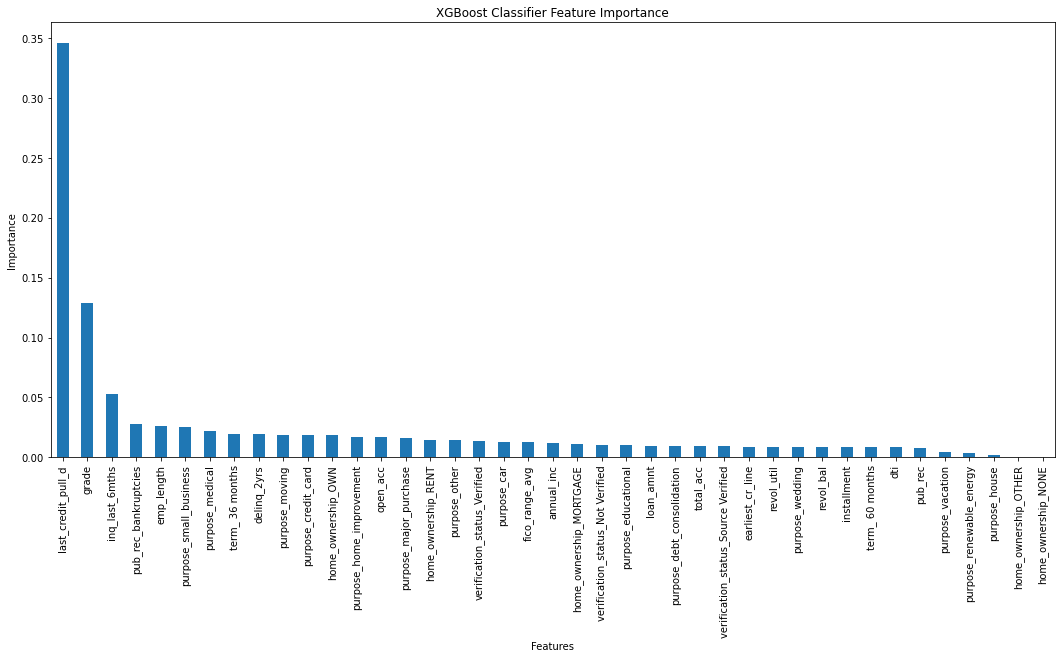

In [28]:
# XGBoost Classifier Feature Importance Bar Plot
plt.subplots(figsize=(18, 8))
imps = xgb.feature_importances_
xgb_feat_imps = pd.Series(imps, index=LC_data.drop("loan_type", axis=1).columns).sort_values(ascending=False)
xgb_feat_imps.plot(kind="bar")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Classifier Feature Importance")

Most notable features of importance according to XGBoost model:
__last_credit_pull_d__, __grade__, __inq_last_6mths__

## 4.6 Save Best Model Object

In [29]:
# Save the best model along with the relevant information
best_model = xgb_rs.best_estimator_
best_model.version = "0.1"
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version

In [30]:
modelpath = r"C:\Users\lastr\Desktop\GitHub\Lending_Club_Capstone\models"
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
LCmodel_path = os.path.join(modelpath, "lending_club_approval_model.pkl")
if not os.path.exists(LCmodel_path):
    with open(LCmodel_path, "wb") as f:
        pickle.dump(best_model, f)